In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-02-08 22:39:44.210744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


In [5]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

train = speech + music
train_labels = np.zeros(len(train))
train_labels[0:len(speech)]=1

In [6]:
train_sounds = load_wav(train)
train_sounds.shape

(104, 661500)

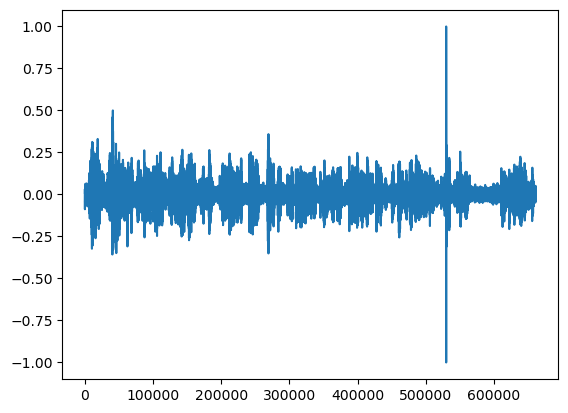

In [7]:
plt.plot(train_sounds[0])
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
print(train_logmag.shape)

(104, 2583, 256)


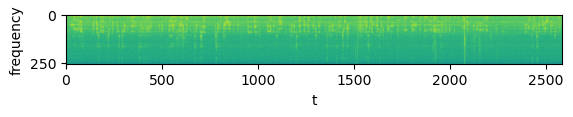

In [9]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [10]:
patch_step = 32
patch_size = 64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)

2023-02-08 22:40:07.175355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(64, 256) : [-7.20707823 -7.01470296] : [-3.10554965 -3.38259778]
(64, 256) : [-7.01470296 -3.93107072] : [-3.38259778 -5.11573692]
(64, 256) : [-3.93107072 -3.26352605] : [-5.11573692 -3.84219093]
(64, 256) : [-3.26352605 -2.98478232] : [-3.84219093 -2.39679103]
(64, 256) : [-2.98478232 -2.43745251] : [-2.39679103 -3.84783553]
(64, 256) : [-2.43745251 -4.33832728] : [-3.84783553 -4.00759411]
(64, 256) : [-4.33832728 -3.49713056] : [-4.00759411 -4.64979471]
(64, 256) : [-3.49713056 -4.85216375] : [-4.64979471 -5.10671424]
(64, 256) : [-4.85216375 -4.38892446] : [-5.10671424 -3.95511945]
(64, 256) : [-4.38892446 -4.16242666] : [-3.95511945 -5.82630202]


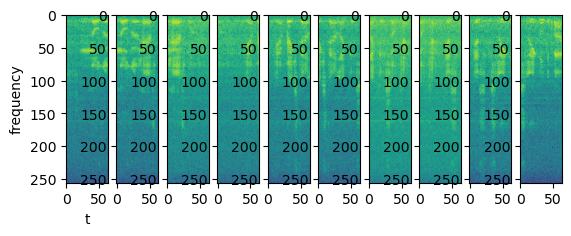

In [12]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [13]:
train_logmag_patches = patches(train_logmag,patch_step,patch_size)
print(train_logmag_patches.shape)

(104, 79, 64, 256)


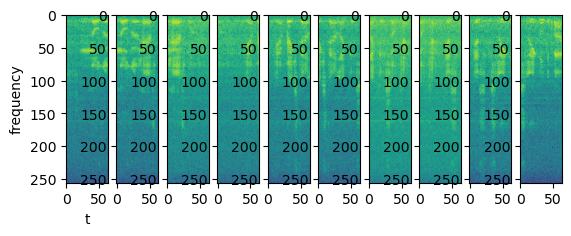

In [14]:
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(train_logmag_patches[0,i].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()